# Laboratorio 2

- **Fecha Inicio**: Miércoles 25 de abril del 2018
- **Fecha Informe**: Domingo 06 de mayo del 2018

## Instalación

Para facilitar el proceso de instalación de esta actividad, trabajaremos con una máquina virtual que tendrá _casi_ todos los programas instalados.

Como motor de máquinas virtuales usaremos [Virtual Box](https://www.virtualbox.org/wiki/Downloads). Desde ese link tendrán que descargar la versión que mejor se ajuste a su sistema operativo. Luego desde los servidores de la universidad deben descargar la [máquina virtual](http://niebla.ing.puc.cl/diplomadobigdata/vbox-pyreclab-lda.ova) ya configurada.

Finalmente debemos importar la máquina descargada dentro de Virtual Box, para ello deben seguir los siguientes pasos: Abrir virtual box > Archivo > Abrir servicio virtualizado, o bien `Crtl+I`.

**Observación:** la contraseña del usuario configurado es _ubuntu_.

Una vez abierto la máquina virtual, abrir la consola o terminal y escribir los siguiente comandos:

```bash
$ sudo apt-get install git
$ sudo pip3 install jupyter
$ sudo pip3 install matplotlib
```

Descargar este proyecto ya sea con `git` o mediante el botón de descargar y ejecutar `notebook`.

```bash
$ git clone https://github.com/stgolarrain/recsys-labs.git
$ cd recsys-labs/assignment-2
$ jupyter notebook
```

## Instrucciones

Al igual que el laboratorio anterior, vamos a utilizar la librería [pyreclab]( https://github.com/gasevi/pyreclab), la cual implementa dos modelos de *implicit feedback* con [Descenso de Gradiente](https://en.wikipedia.org/wiki/Gradient_descent) y [Alternating Least Square (ALS)](https://web.stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf). También contarán con un pequeño set de datos ubicado en la carpeta `/dataset`, el cual incluye dos archivos: `movies.dat` y `ratings.dat`.

Como es de esperarse el archivo `movies.dat` cuenta con metadatos de películas, mientras que `ratings.dat` contiene los *ratings* que diferentes usuarios le asignaron a diferentes películas. El formato de cada archivo es como sigue:

- `movies.dat`: `movie_id; title; genres`
- `ratings.dat`: `user_id; movie_id; rating; timestamp`

Los datos de `genres` corresponden a las categorías de la película separados por el caracter |.

En este laboratorio tendrán que implementar las siguientes tareas:

1. Descripción preliminar del set de datos
2. Entrenar y evaluar los modelos de factorización utilizando ambos métodos
3. Visualizar los vectores latentes mediante la técnica PCA

## 1. Descripción de los Datos

En esta sección utilizaremos la librería [Pandas](https://pandas.pydata.org/) para el manejo de *data frames*.

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# Load movies dataset
movies_path = './dataset/movies.dat'
headers = ['movie_id', 'title', 'genres']
movies = pd.read_csv(movies_path,
                     names=headers,
                     delimiter=';',
                     usecols=['movie_id', 'title'])

movies[:5]

,movie_id,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [15]:
print('# Movies:', movies['movie_id'].nunique())

# Movies: 3883


**Pregunta** ¿Cuántas películas tiene el set de datos?

**Respuesta**

In [17]:
# Load rating dataset
ratings_path = './dataset/ratings.dat'
headers = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(ratings_path,
                     names=headers,
                     delimiter=';',
                     usecols=['user_id', 'movie_id', 'rating'])

ratings[:5]

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [ ]:
# TODO: Code your answer here

**Pregunta** ¿Cuántos usuarios tiene el set de datos?

** Respuesta**

In [ ]:
# TODO: Code your answer here

**Pregunta** ¿Cuál es el porcentaje de densidad que tiene la matriz usuario-items?

** Respuesta**

In [37]:
# Top 5 most popular movies
top_5_count = ratings.groupby(['movie_id'], as_index=False)[['rating']].count().head(5)
top_5_count = top_5_count.merge(movies, on='movie_id', how='inner')
top_5_count

,movie_id,rating,title
0,1,2077,Toy Story (1995)
1,2,701,Jumanji (1995)
2,3,478,Grumpier Old Men (1995)
3,4,170,Waiting to Exhale (1995)
4,5,296,Father of the Bride Part II (1995)


In [36]:
# Top 5 most like movies (average rating)
top_5_mean_rating = ratings.groupby(['movie_id'], as_index=False)[['rating']].mean().head(5)
top_5_mean_rating = top_5_mean_rating.merge(movies, on='movie_id', how='inner')
top_5_mean_rating

,movie_id,rating,title
0,1,4.146846,Toy Story (1995)
1,2,3.201141,Jumanji (1995)
2,3,3.016736,Grumpier Old Men (1995)
3,4,2.729412,Waiting to Exhale (1995)
4,5,3.006757,Father of the Bride Part II (1995)


**Pregunta** ¿Cuales son las películas menos populares en términos de cantidad?

*Hint* Te recomendamos utilizar la función [`tail`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.tail.html) de Pandas

**Respuesta**

In [30]:
# TODO: Code your answer here

**Pregunta** ¿Cuales son las películas menos populares en términos de rating promedio?

**Respuesta**

In [33]:
# TODO: Code your answer here

**Pregunta** Describa las listas de películas menos populares ¿Se parecen las listas de películas menos populares? ¿Por qué?

**Respuesta**

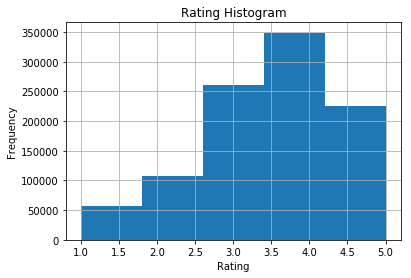

In [52]:
# Rating Histogram
ratings['rating'].hist(bins=5)
plt.title('Rating Histogram')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

**Pregunta**: ¿El set de datos tiene problemas de `cold-start` o ítems con pocos ratings? Justifique generando un histograma con los ratings por usuario y por ítems.

*Hint*: recomendamos utilizar el parámetro bins en el histograma para visualizar la respuesta.

**Respuesta**

In [ ]:
# TODO: Code your answer

## 2. Factorización Matricial